In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from decoding_functions import *
from spot_detection_functions import *
from reading_data_functions import *

In [3]:
# data_path has to contain channel_info.csv, taglist.csv, tile_names.csv and selected_tiles directory with registered tif files
#dataset_name = 'N1C_OB10036_x20'
dataset_name = 'N1234F_OB10037_x20'
#dataset_name = 'N1234F_OB10037_20x_fake-anchor'
data_path = '/nfs/research1/gerstung/mg617/ISS_data/' + dataset_name + '/'
#data_path = '/Users/mg617/nfs/research1/gerstung/mg617/ISS_data/' + dataset_name + '/'

In [4]:
# read channel_info.csv and taglist.csv
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info(data_path)

In [5]:
# input parameters for loading the tiles and for spot detection
tifs_path = data_path + 'selected_2k_tiles/'
tile_names = read_csv(data_path + 'tile_names.csv')
tiles_info={'tile_size':2000, 'y_max':17, 'x_max':15, 'y_max_size':2000, 'x_max_size':2000, 'filename_prefix':'cycles_combined_opt_flow_registered_'}
#tiles_to_load = {'y_start':10, 'y_end':tiles_info['y_max'], 'x_start':0, 'x_end':tiles_info['x_max']} #lower part
#tiles_to_load = {'y_start':0, 'y_end':9, 'x_start':0, 'x_end':tiles_info['x_max']} #upper part
tiles_to_load = {'y_start':2, 'y_end':2, 'x_start':3, 'x_end':3} # one tile
spots_params = {'trackpy_diam_detect':5, 'trackpy_search_range':6, 'spot_diam_tophat':5, 'trackpy_prc':75} # parameters for spot detection

In [6]:
# load tile by tile and extract spots in each using trackpy
spots, spots_loc, _= load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, 
                                                 ind_cy_move_forward_by=1, #becuase c01 is the reference cylce without coding channels
                                                 anchor_available=False, #fake anchors should be generated for spot detection
                                                 correct_reg_via_trackpy=True) #trackpy corrects registration by linear shifting using fake anchors but keeps spots from first frame only

Extracting spots from: X3_Y2 

In [ ]:
# #Save extracted spots
# extracted_spots_path = data_path + 'decoding/extracted-spots/'
# with open(extracted_spots_path + dataset_name + '_spots_params_shift_0_75_noth_up.pickle', 'wb') as fp:
#         pickle.dump(spots_params, fp)
# np.save(extracted_spots_path + dataset_name + '_spots_shift_0_75_noth_up.npy', spots)
# spots_loc.to_csv(extracted_spots_path + dataset_name + '_spots_locations_shift_0_75_noth_up.csv', index=False)

In [ ]:
# #Load extracted spots
# extracted_spots_path = data_path + 'decoding/extracted-spots/'
# spots = np.load(extracted_spots_path + dataset_name + '_spots_shift_0_75_noth_up.npy')
# spots_loc = read_csv(extracted_spots_path + dataset_name + '_spots_locations_shift_0_75_noth_up.csv')

In [ ]:
# # If comparing spots with differnet parameters
# spots_loc = spots_loc.sort_values('Y').sort_values('X').sort_values('Tile')
# spots = spots[spots_loc.index.to_numpy(dtype=np.int64),:,:]

In [7]:
print('In total {} spots detected'.format(spots.shape[0]))

In total 3848 spots detected


In [ ]:
# # If removing tiles from the upper part
# y_coord = np.floor(spots_loc.Y.to_numpy(dtype=np.double)).astype(np.int32)
# ind_keep = y_coord>2000
# spots = spots[ind_keep,]
# spots_loc = spots_loc[ind_keep].reset_index()
# del spots_loc['index']

# y_coord = np.floor(spots_loc.Y.to_numpy(dtype=np.double)).astype(np.int32)
# x_coord = np.floor(spots_loc.X.to_numpy(dtype=np.double)).astype(np.int32)
# ind_keep = (y_coord<4*2000) 
# ind_keep = ind_keep*(x_coord>12*2000)
# spots = spots[~ind_keep,]
# spots_loc = spots_loc[~ind_keep].reset_index()
# del spots_loc['index']

# y_coord = np.floor(spots_loc.Y.to_numpy(dtype=np.double)).astype(np.int32)
# x_coord = np.floor(spots_loc.X.to_numpy(dtype=np.double)).astype(np.int32)
# ind_keep = (y_coord>4*2000)*(y_coord<5*2000) 
# ind_keep = ind_keep*(x_coord>4.4*2000)*(x_coord<5.4*2000)
# spots = spots[~ind_keep,]
# spots_loc = spots_loc[~ind_keep].reset_index()
# del spots_loc['index']

# print('In total {} spots detected'.format(spots.shape[0]))

In [ ]:
# #If masking the tissue with the saved masks
# mask_path = data_path + 'decoding/tissue_mask_up_1.mat'
# matlab_mask = loadmat(mask_path, squeeze_me=True)
# from skimage.transform import rescale
# mask = rescale(matlab_mask['tissue_mask'],matlab_mask['mask_is_resized_by'])
# mask = mask > 0

# x_coord = np.floor(spots_loc.X.to_numpy(dtype=np.double)).astype(np.int32)
# y_coord = np.floor(spots_loc.Y.to_numpy(dtype=np.double)).astype(np.int32)
# ind_keep = mask[y_coord,x_coord]
# spots = spots[ind_keep,]
# spots_loc = spots_loc[ind_keep].reset_index()
# del spots_loc['index']

# print('In total {} spots kept'.format(spots.shape[0]))

In [ ]:
# #Save extracted spots after masking
# extracted_spots_path = data_path + 'decoding/extracted-spots/'
# with open(extracted_spots_path + dataset_name + '_spots_params_shift_0_75_noth_up_masked.pickle', 'wb') as fp:
#         pickle.dump(spots_params, fp)
# np.save(extracted_spots_path + dataset_name + '_spots_shift_0_75_noth_up_masked.npy', spots)
# spots_loc.to_csv(extracted_spots_path + dataset_name + '_spots_locations_shift_0_75_noth_up_masked.csv', index=False)

In [8]:
# estimate GMM parameters and compute class probabilities 
out = decoding_function(spots, barcodes_01, print_training_progress=True)#, estimate_additional_barcodes=estimate_additional_barcodes)
# creating a data frame from the decoding output
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

  0%|          | 0/60 [00:00<?, ?it/s]/homes/mg617/virtualEnvs/pytorch/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 60/60 [00:37<00:00,  1.58it/s]


In [ ]:
# #Save decoding output
# with open(data_path + 'decoding/' + dataset_name + '_out_shift_0_Gauss05.pickle', 'wb') as fp:
#     pickle.dump(out, fp)

In [ ]:
# ## Load saved decoding results
# with open(data_path + 'decoding/' + dataset_name + '_out_shift.pickle', 'rb') as fp:
#      out = pickle.load(fp)
# df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
# df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['NA','0000','NA']))
# decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
# decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

The initial loss is 35.56167976871102 and the final loss is 22.914486827572766


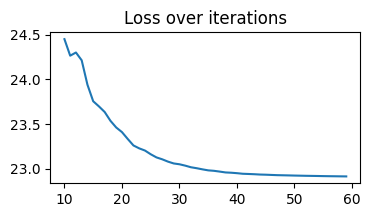

In [9]:
print('The initial loss is {} and the final loss is {}'.format(1/out['class_probs'].shape[0]*out['params']['losses'][0],1/out['class_probs'].shape[0]*out['params']['losses'][len(out['params']['losses'])-1]))
plt.figure(num=None, figsize=(4, 2), dpi=100, facecolor='w', edgecolor='k')
plt.plot(np.arange(10,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'][10:])))
plt.title('Loss over iterations')
plt.show()

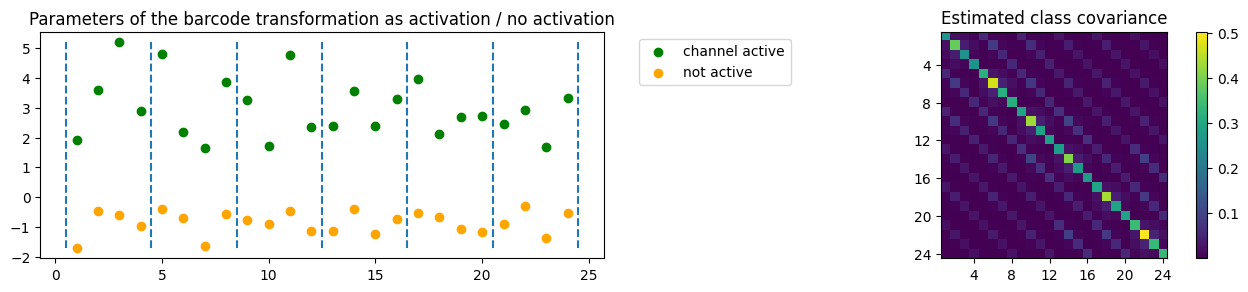

In [10]:
# plot estimated parameters for class means and covariance
plt.figure(num=None, figsize=(16, 3), dpi=100, facecolor='w', edgecolor='k')
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,1+R*C),activation,c='green') 
plt.scatter(np.arange(1,1+R*C),no_activation,c='orange') 
plt.legend(('channel active','not active'),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
plt.title('Parameters of the barcode transformation as activation / no activation')
plt.subplot(1, 2, 2)
plt.imshow(out['params']['sigma_star'])
plt.yticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.xticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.colorbar()
plt.title('Estimated class covariance')
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_params_shift_0_75_noth.png')
#plt.savefig(data_path + 'decoding/' +'params_shift_0_75_noth_up_masked.png')
plt.show()

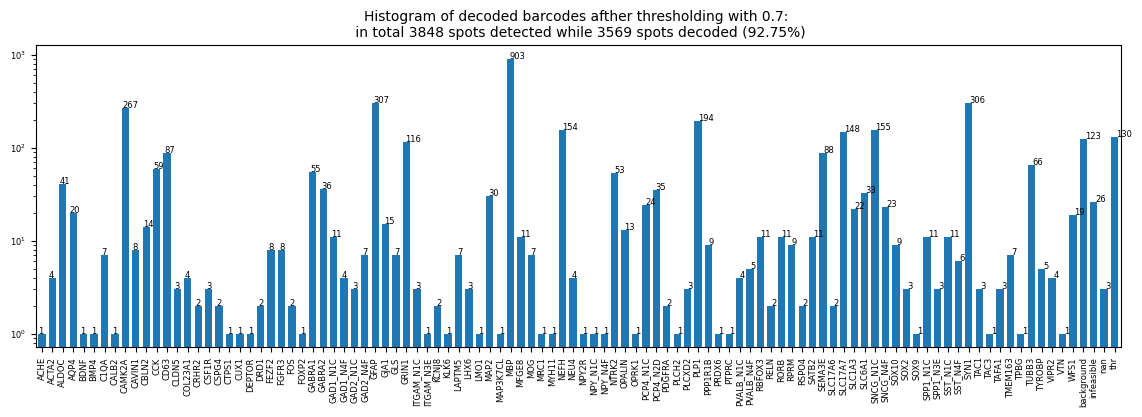

In [11]:
# plot a histogram of class assignments when class probabilities are thresholded by thr
thr=0.7
df =  pd.concat([decoded_df.Name[decoded_df.Probability >thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
plt.figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')
ax = df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,figsize=(14,4))
ax.set_facecolor('w')
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
#ax.legend(["gmm: {} decoded spots with prob > {}".format(num_decoded_barcodes,thr)],fontsize=8)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df.shape[0], 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram_shift_0_75_noth.png')
#plt.savefig(data_path + 'decoding/' + 'histogram_shift_0_75_noth_up_masked.png')
plt.show()

In [12]:
print('Class names: {}'.format(np.unique(decoded_df.Name)))

Class names: ['ACHE' 'ACTA2' 'ADAMTS2' 'ADARB2' 'ALDOC' 'AQP4' 'ARHGAP36' 'BDNF' 'BMP4'
 'C1QA' 'CALB2' 'CAMK2A' 'CAVIN1' 'CBLN2' 'CCK' 'CD63' 'CLDN5' 'COL23A1'
 'CRHR2' 'CSF1R' 'CSPG4' 'CTPS1' 'CUX1' 'DEPTOR' 'DRD1' 'FEZF2' 'FGFR3'
 'FOS' 'FOXP2' 'GABRA1' 'GABRA2' 'GAD1_N1C' 'GAD1_N4F' 'GAD2_N1C'
 'GAD2_N4F' 'GFAP' 'GJA1' 'GLS' 'GRIN1' 'ITGAM_N1C' 'ITGAM_N3E' 'KCNJ8'
 'KLK6' 'LAPTM5' 'LHX6' 'LMO1' 'MAP2' 'MAP3K7CL' 'MBP' 'MFGE8' 'MIA' 'MOG'
 'MRC1' 'MYH11' 'NEFH' 'NEU4' 'NPY2R' 'NPY_N1C' 'NPY_N4F' 'NTRK2' 'OPALIN'
 'OPRK1' 'PCP4_N1C' 'PCP4_N2D' 'PDGFRA' 'PLCH2' 'PLCXD2' 'PLP1' 'PPP1R1B'
 'PRDX6' 'PTPRC' 'PVALB_N1C' 'PVALB_N4F' 'RBFOX3' 'RELN' 'RORB' 'RPRM'
 'RSPO4' 'SATB2' 'SEMA3E' 'SLC17A6' 'SLC17A7' 'SLC1A3' 'SLC6A1' 'SNCG_N1C'
 'SNCG_N4F' 'SOX10' 'SOX2' 'SOX9' 'SPP1_N1C' 'SPP1_N3E' 'SST_N1C'
 'SST_N4F' 'SYN1' 'TAC1' 'TAC3' 'TAFA1' 'TMEM163' 'TPBG' 'TUBB3' 'TYROBP'
 'VIPR2' 'VTN' 'WFS1' 'background' 'infeasible' 'nan']


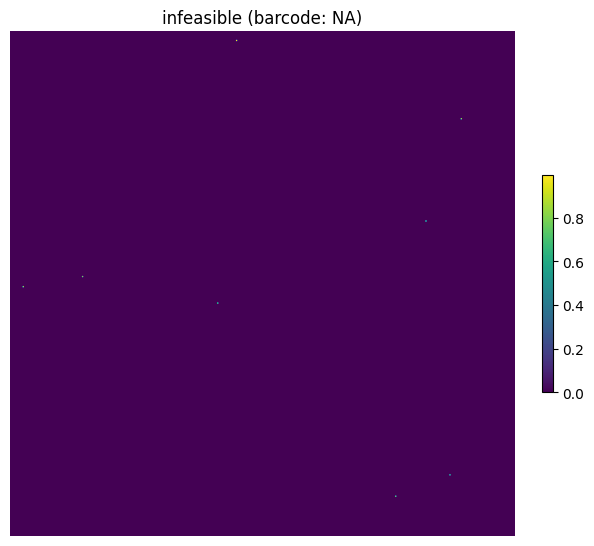

In [13]:
# plot any of the classes listed above
name = 'infeasible'
thr = 0.7
grid = 5
plot_probs = True
x_coord = np.floor(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
y_coord = np.floor(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
D_gmm = np.zeros((int(np.ceil(decoded_df.Y.to_numpy(dtype=np.double).max()/grid)),int(np.ceil(decoded_df.X.to_numpy(dtype=np.double).max()/grid))))
if plot_probs:
    prob = decoded_df.Probability[decoded_df.Name == name].to_numpy(dtype=np.double)
    prob[prob<thr]=0
    for i in range(len(x_coord)):
        D_gmm[y_coord[i],x_coord[i]] = D_gmm[y_coord[i],x_coord[i]] + prob[i]
else:
    coords = np.concatenate((y_coord.reshape((len(x_coord),1)),x_coord.reshape((len(x_coord),1))), axis=1)
    coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
    D_gmm[coords_u[:,0],coords_u[:,1]]=coords_c
plt.figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log2(1+D_gmm))
plt.axis('off')
plt.colorbar(fraction=0.02)
plt.title('{} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name + '_decoded_' + name +'_shift_0_75_noth.png')
#plt.savefig(data_path + 'decoding/' + name + '_shift_0_75_noth_up_masked.png')
plt.show()

In [ ]:
## save dataframe with decoded spots
#decoded_df.to_csv(data_path + 'decoding/' + dataset_name + '_GMMdecoding_shift_0_75_noth_up_masked.csv', index=False)